# Amazon Direction Multi-Class Classification Model
-----------------

### Target Creation
The target of the below dataset is the column 'Direction'. It is a multiclass variable with a performance window of 60 minutes with the following classes:

- **0: No significant change**: The stock does not show a significant change within the performance window.
- **1: Increase**: The stock shows a slight increase within the performance window.
- **2: Decrease**: The stock shows a moderate increase within the performance window.

60 minutes is chosen as the best window of time because it has enough variance to add data points to each class but also represents a good window of time where there may not be a vast amount of variance in between.

The classification of increases and decreases is based on specific thresholds of the stock moving up or down by certain percentages in that hour. This is based on the ratio of the closing price to the closing price 60 minutes before. 

Below we will show some baseline stats for the target variable and define the prediction period we will use.


### Prediction Period

The prediction period chosen for this analysis is:

- **Period**: 3 days - 1,170 rows

This period was selected because the data is minute-to-minute, suggesting a semi-high frequency trading model. The 3-day period can capture short-term trends.
More periods can be tested in future analysis.



In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import RandomizedSearchCV
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.exceptions import ConvergenceWarning
import warnings

In [2]:



def dataframe_to_html(df):
    """
    Convert a DataFrame to an HTML table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.

    Returns:
    str: The HTML representation of the DataFrame.
    """
    # Convert the DataFrame to an HTML table
    html = df.to_html()
    
    # Return the HTML string
    return html



def htmldf(df):
    """
    Display a DataFrame as an HTML table in a Jupyter notebook.

    Parameters:
    
    df (pd.DataFrame): The DataFrame to display.
    """
    # Convert the DataFrame to an HTML table
    html = dataframe_to_html(df)
    
    # Display the HTML table
    display(HTML(html))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

filtered_df = pd.read_csv('amzn_preprocessed_final.csv')
htmldf(filtered_df.head(5))

,timestamp,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized,Direction
0,2023-08-07 18:38:00+00:00,141.98,55506.779414,99508.0,126.08766,329.860,131.090,314.61,160.74,96.1928,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.007395,0.451289,1.475994,1.083073,45.7872,-187.880,-0.04,-0.13,-0.12,-0.16,-0.19,1.0,0
1,2023-08-07 18:39:00+00:00,141.98,55341.989940,99508.0,126.08766,329.715,131.075,314.39,160.74,96.1928,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.007395,0.451605,1.475994,1.083197,45.7872,-187.735,0.00,-0.04,-0.13,-0.12,-0.16,1.0,0
2,2023-08-07 18:40:00+00:00,141.99,57382.989940,101549.0,126.08766,329.735,131.085,314.34,160.70,96.1928,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.007145,0.451708,1.476098,1.083190,45.7972,-187.745,0.01,0.01,-0.03,-0.12,-0.11,1.0,0
3,2023-08-07 18:41:00+00:00,142.01,58064.418511,103139.0,126.08766,329.720,131.120,314.34,160.69,96.1928,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.007082,0.451772,1.476306,1.083054,45.8172,-187.710,0.02,0.03,0.03,-0.01,-0.10,1.0,0
4,2023-08-07 18:42:00+00:00,142.04,58222.418511,104245.0,126.08766,329.630,131.055,314.34,160.66,96.1928,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1.006894,0.451867,1.476618,1.083820,45.8472,-187.590,0.03,0.05,0.06,0.06,0.02,1.0,0


* The plot below shows the class proportions for each of the directional classifiers within the data-set

In [4]:
filtered_df = filtered_df.drop(columns = 'Direction')

* Above we can see there class weights for the up and down classes is about even while the neutral class makes up the majority of the data, this is expected when dealing with stock pricing.
------------------------

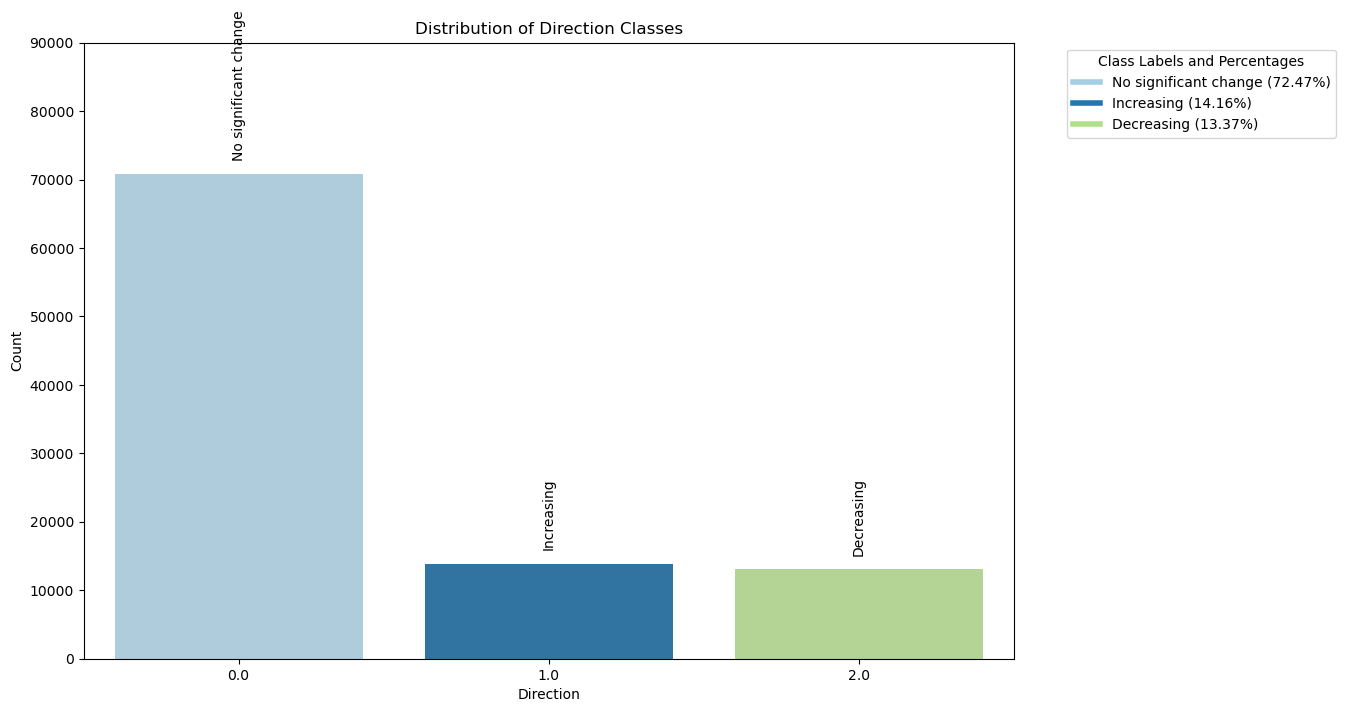

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_target_classes(df, column='close', period=60):
    df['Future_Close'] = df[column].shift(-period)  # Look forward 60 minutes
    df['Pct_Change'] = (df['Future_Close'] / df[column]) - 1
    conditions = [
        (df['Pct_Change'] <= -0.005),
        (df['Pct_Change'] > -0.005) & (df['Pct_Change'] <= 0.005),
        (df['Pct_Change'] > 0.005)
    ]
    choices = [2, 0, 1]
    df['Direction'] = np.select(conditions, choices, default=np.nan)
    df = df.drop(columns=['Future_Close', 'Pct_Change'])
    return df.dropna(subset=['Direction'])

# Apply the function to the DataFrame
filtered_df = create_target_classes(filtered_df)

# Calculate the percentages for each class
direction_counts = filtered_df['Direction'].value_counts()
total_counts = direction_counts.sum()
direction_percentages = (direction_counts / total_counts * 100).round(2)

# Plot the distribution of the Direction column
plt.figure(figsize=(12, 8))
sns.countplot(x='Direction', data=filtered_df, hue='Direction', palette='Paired', dodge=False, legend=False)

# Annotate the plot with the class labels
annotations = {
    0: "No significant change",
    1: "Increasing",
    2: "Decreasing"}

for direction, label in annotations.items():
    plt.text(direction, direction_counts[direction] + 2000, label, ha='center', fontsize=10, rotation=90, va='bottom')

plt.title('Distribution of Direction Classes')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.ylim(0, 90000)  # Set the y-axis limit to 90,000

# Create a custom legend with percentages
handles = []
for direction, label in annotations.items():
    handles.append(
        plt.Line2D([0], [0], color=sns.color_palette('Paired')[direction], lw=4, label=f'{label} ({direction_percentages[direction]}%)')
    )

plt.legend(handles=handles, title='Class Labels and Percentages', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [6]:
proportions = filtered_df['Direction'].value_counts(normalize=True) * 100

# Print the proportions
print(proportions)

Direction
0.0    72.468620
1.0    14.159346
2.0    13.372033
Name: proportion, dtype: float64


Below are some descriptive statistics for the input variables

In [7]:
input_vars = filtered_df.drop(columns = 'Direction')
htmldf(input_vars.describe())

,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized
count,97674.000000,9.767400e+04,9.767400e+04,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000
mean,161.664129,1.190788e+06,2.825780e+06,161.582970,387.831465,149.114582,407.377684,117.886154,78.644082,0.233675,0.063251,0.233686,0.063968,0.199797,0.174878,0.133659,0.146805,0.179741,0.200555,0.174263,0.132942,0.146549,0.180376,0.997005,0.403561,2.081551,1.084645,83.020047,-226.167336,0.000252,0.000503,0.000755,0.001010,0.001266,1.500082
std,22.074108,9.396894e+05,1.712583e+06,20.573298,42.101672,18.215281,84.562730,48.609477,6.592588,0.423170,0.243416,0.423177,0.244697,0.399850,0.379864,0.340287,0.353913,0.383973,0.400418,0.379338,0.339514,0.353657,0.384502,0.058194,0.035868,0.387050,0.083054,26.299991,21.999049,0.152185,0.214107,0.262139,0.299656,0.332292,1.118360
min,124.480000,-2.726624e+05,-6.223696e+04,126.087660,312.680000,123.460000,286.360000,58.810000,68.477200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337901,0.330001,1.420903,0.913658,38.370000,-266.735000,-8.545000,-8.610000,-11.150000,-11.600000,-11.670000,0.000000
25%,141.565000,1.956560e+05,1.236917e+06,143.704843,347.841250,135.250000,319.370000,64.890000,73.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994453,0.369057,1.643240,1.038048,54.636250,-241.410000,-0.050000,-0.070000,-0.090000,-0.100000,-0.115000,0.000000
50%,166.842500,1.598499e+06,3.641042e+06,161.823374,401.210000,141.377500,432.295000,154.770000,76.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001679,0.401434,2.195341,1.072161,91.052500,-230.545000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,182.010000,2.024507e+06,4.369658e+06,179.584659,420.623750,166.480000,488.930000,161.520000,83.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.009280,0.435232,2.390373,1.122605,105.710000,-213.030000,0.050000,0.075000,0.095000,0.110000,0.120000,3.000000
max,199.745000,2.696474e+06,4.857056e+06,196.350906,463.737800,189.530000,530.855600,174.340000,96.192800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.087927,0.476935,2.768031,1.357559,126.985000,-180.450000,9.700000,9.930000,10.790000,9.400000,9.560000,3.000000


In [8]:
# Calculate class weights
classes = filtered_df['Direction'].unique()
y_train = filtered_df['Direction']
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

class_weights_dict

{0.0: 0.45996920164446264, 2.0: 2.4927647193936147, 1.0: 2.354157628344179}

In [13]:
def optimize_memory_usage(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Function to create additional features
def create_additional_features(df):
    df['SMA_15'] = df['close'].rolling(window=15).mean()
    df['SMA_60'] = df['close'].rolling(window=60).mean()
    df['Volatility'] = df['close'].rolling(window=60).std()
    df['Lag_1'] = df['close'].shift(1)
    df['Lag_5'] = df['close'].shift(5)
    df['Lag_10'] = df['close'].shift(10)
    df['RSI'] = compute_RSI(df['close'], window=14)  # Implement compute_RSI function
    df = df.dropna()
    return df

def compute_RSI(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# Function to remove constant features
def remove_constant_features(df):
    constant_features = [col for col in df.columns if df[col].nunique() <= 1]
    return df.drop(columns=constant_features)

def cluster_features(df, n_clusters=10):
    fa = FeatureAgglomeration(n_clusters=n_clusters)
    reduced_features = fa.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_features, index=df.index, columns=[f'cluster_{i}' for i in range(n_clusters)])
    return reduced_df
    
# Function to select top K features
def select_top_k_features(X, y, k=10):
    selector = SelectKBest(f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    return X_new, selected_features

def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    try:
        auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
        print(f"AUC Score: {auc}")
    except ValueError:
        print("AUC Score: Not applicable for multi-class with current configuration")

    # Plot the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

def split_data(df, validation_start, test_start):
    train_df = df[:validation_start]
    validation_df = df[validation_start:test_start]
    test_df = df[test_start:]
    return train_df, validation_df, test_df
# Optimize memory usage by downcasting data types
filtered_df = filtered_df.drop(columns=['timestamp', 'Close_Discretized'])
filtered_df = optimize_memory_usage(filtered_df)

# Create additional features
filtered_df = create_additional_features(filtered_df)

Completed 25% of training
Completed 50% of training
Completed 75% of training
Lookback period: 4320
Validation Set Performance:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     13859
         1.0       0.00      0.00      0.00      2770
         2.0       0.14      1.00      0.24      2600

    accuracy                           0.14     19229
   macro avg       0.05      0.33      0.08     19229
weighted avg       0.02      0.14      0.03     19229

Model training and evaluation complete.
Confusion Matrix:
[[    0     0 13859]
 [    0     0  2770]
 [    0     0  2600]]
Accuracy: 0.1352124395444381
Precision: 0.018282403807558325
Recall: 0.1352124395444381
F1 Score: 0.032209660801277115
AUC Score: Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

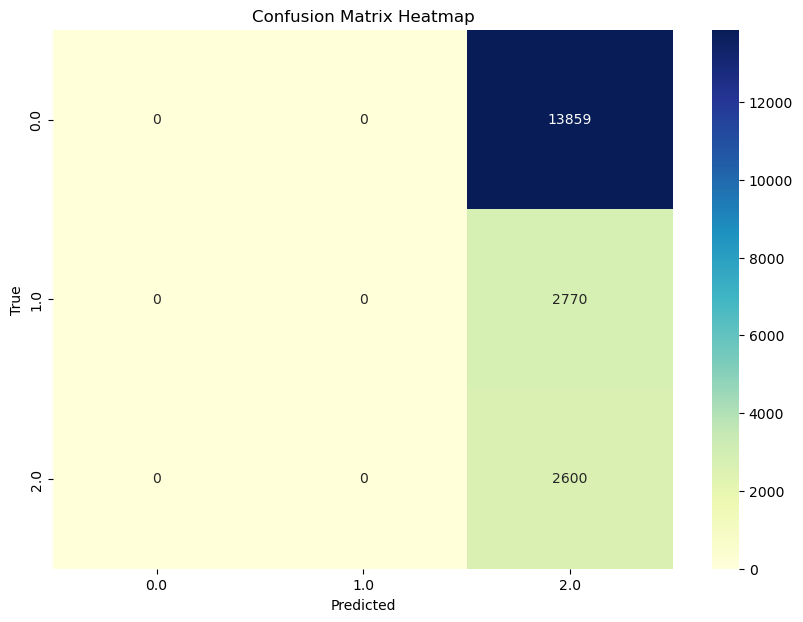

In [10]:
def train_validate_and_evaluate_model(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns

    # Initialize incremental learning model
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight={0: 0.45996920164446264, 2: 2.4927647193936147, 1: 2.354157628344179})

    
    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period
    quartiles = [int(total_windows * 0.25), int(total_windows * 0.5), int(total_windows * 0.75)]

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError as e:
            print(f"Error during partial_fit in window {start} to {end}: {e}")
            continue

        if end - lookback_period in quartiles:
            quartile = quartiles.index(end - lookback_period) + 1
            print(f"Completed {quartile * 25}% of training")

    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return y_val.tolist(), []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return y_val.tolist(), []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val


# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model(train_df, validation_df, lookback_period=4320, target_column='Direction')

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)

Completed 25% of training
Completed 50% of training
Completed 75% of training
Lookback period: 10080
Validation Set Performance:
              precision    recall  f1-score   support

         0.0       0.68      0.33      0.45     13859
         1.0       0.13      0.49      0.21      2770
         2.0       0.12      0.11      0.11      2600

    accuracy                           0.32     19229
   macro avg       0.31      0.31      0.26     19229
weighted avg       0.52      0.32      0.37     19229

Model training and evaluation complete.
Confusion Matrix:
[[4620 7503 1736]
 [1154 1349  267]
 [1068 1253  279]]
Accuracy: 0.32492589318217274
Precision: 0.5224315595664927
Recall: 0.32492589318217274
F1 Score: 0.36734482249492156
AUC Score: Not applicable for multi-class with current configuration


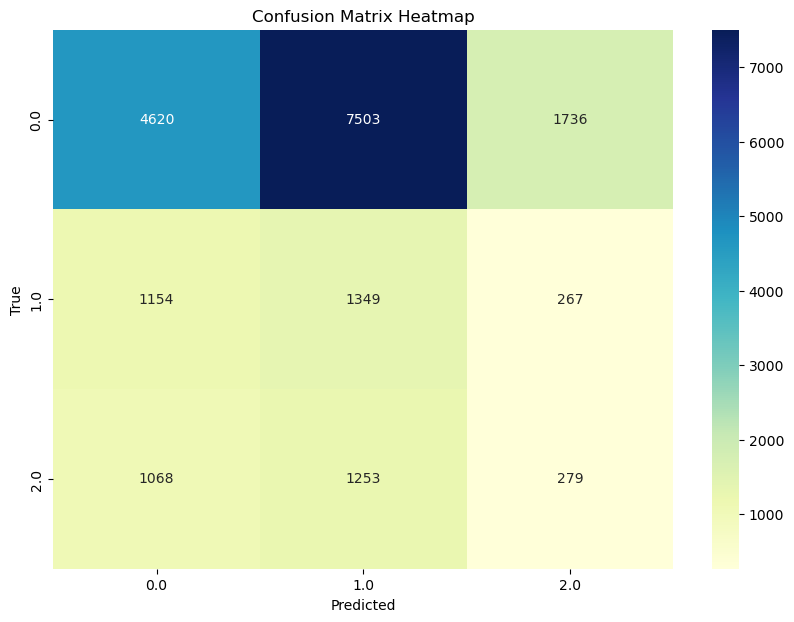

In [10]:
def train_validate_and_evaluate_model(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns

    # Initialize incremental learning model
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight={0: 0.45996920164446264, 2: 2.4927647193936147, 1: 2.354157628344179})

    
    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period
    quartiles = [int(total_windows * 0.25), int(total_windows * 0.5), int(total_windows * 0.75)]

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError as e:
            print(f"Error during partial_fit in window {start} to {end}: {e}")
            continue

        if end - lookback_period in quartiles:
            quartile = quartiles.index(end - lookback_period) + 1
            print(f"Completed {quartile * 25}% of training")

    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return y_val.tolist(), []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return y_val.tolist(), []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val


# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model(train_df, validation_df, lookback_period=10080, target_column='Direction')

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)



BHBHBHB

In [ ]:
def train_validate_and_evaluate_model_sgd(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Initialize incremental learning model with more balanced class weights
    class_weights = {0: 0.5, 1: 3, 2: 3}  # Adjusted class weights
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights)

    unique_classes = train_df[target_column].unique()

    # Scaling and PCA
    scaler = StandardScaler()
    pca = PCA(n_components=10)  # Adjust number of components

    total_windows = len(train_df) - lookback_period
    print(f"Total training windows: {total_windows}")
    
    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        # Convert string columns to object type (optional: before fillna)
        X_train = X_train.convert_dtypes()
        
        # Apply fillna only to numeric columns
        X_train = X_train.fillna(X_train.select_dtypes(include=['number']).mean(numeric_only=True))
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            continue

        X_train_scaled = scaler.fit_transform(X_train)
        X_train_pca = pca.fit_transform(X_train_scaled)

        try:
            model.partial_fit(X_train_pca, y_train, classes=unique_classes)
        except ValueError as e:
            continue

        # Print progress update
        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    # Convert string columns to object type (optional: before fillna)
    X_val = X_val.convert_dtypes()
    
    # Apply fillna only to numeric columns
    X_val = X_val.fillna(X_val.select_dtypes(include=['number']).mean(numeric_only=True))
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        return y_val.tolist(), []

    X_val_scaled = scaler.transform(X_val)
    X_val_pca = pca.transform(X_val_scaled)

    try:
        y_pred_val = model.predict(X_val_pca)
    except NotFittedError as e:
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data using Dask for efficiency
filtered_df_dd = dd.from_pandas(filtered_df, npartitions=10, sort=False)  # Avoid sorting to prevent PyArrow usage
train_df, validation_df, test_df = filtered_df_dd.loc[:validation_start].compute(), filtered_df_dd.loc[validation_start:test_start].compute(), filtered_df_dd.loc[test_start:].compute()

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model_sgd(train_df, validation_df, lookback_period=7800, target_column='Direction')

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)


Total training windows: 58615
Training progress: 0.00%


In [11]:
def train_validate_and_evaluate_model_extra_trees(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Initialize ExtraTreesClassifier with warm start
    model = ExtraTreesClassifier(n_estimators=10, warm_start=True, class_weight=class_weights_dict, random_state=42)

    unique_classes = train_df[target_column].unique()

    # Scaling
    scaler = StandardScaler()

    total_windows = len(train_df) - lookback_period
    print(f"Total training windows: {total_windows}")

    first_fit = True

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]

        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        # Select only numeric columns for calculating the mean and filling NaNs
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns
        X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].mean())

        X_train = remove_constant_features(X_train)
        X_train_scaled = scaler.fit_transform(X_train)

        # Select top K features
        X_train_selected, selected_features = select_top_k_features(X_train_scaled, y_train, k=10)

        try:
            if first_fit:
                model.fit(X_train_selected, y_train)
                first_fit = False
            else:
                model.n_estimators += 10
                model.fit(X_train_selected, y_train)
        except ValueError as e:
            continue

        # Print progress update
        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    # Select only numeric columns for calculating the mean and filling NaNs
    numeric_cols = X_val.select_dtypes(include=[np.number]).columns
    X_val[numeric_cols] = X_val[numeric_cols].fillna(X_val[numeric_cols].mean())

    X_val = remove_constant_features(X_val)
    X_val_scaled = scaler.transform(X_val)

    # Select top K features using the same selected features
    X_val_selected = X_val_scaled[:, selected_features]

    try:
        y_pred_val = model.predict(X_val_selected)
    except NotFittedError as e:
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data using Dask for efficiency
filtered_df_dd = dd.from_pandas(filtered_df, npartitions=10, sort=False)  # Avoid sorting to prevent PyArrow usage
train_df, validation_df, test_df = filtered_df_dd.loc[:validation_start].compute(), filtered_df_dd.loc[validation_start:test_start].compute(), filtered_df_dd.loc[test_start:].compute()

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model_extra_trees(train_df, validation_df, lookback_period=1170, target_column='Direction')

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)

NameError: name 'train_validate_and_evaluate_model_extra_trees' is not defined

# Decision Tree